# Init

## Imports

In [1]:
%matplotlib notebook

In [2]:
from importlib import reload
from typing import Dict, Tuple, List, Union, Sequence, Optional

import numpy as np
from matplotlib import pyplot as plt

In [36]:
import qcodes as qc
from qcodes.dataset.measurements import Measurement, ParamSpec
from qcodes.instrument.base import Instrument, InstrumentBase
from qcodes.instrument.parameter import Parameter, ArrayParameter

from pytopo.qctools.instruments import create_inst
from pytopo.qctools import dataset2 as d2

from pytopo.qctools import hard_sweep; reload(hard_sweep)
from pytopo.qctools.hard_sweep import HardSweep, HardSweepDetector, make_dataset, make_measurement

from pytopo.qctools import measurement; reload(measurement)
from pytopo.qctools.measurement import MeasurementExt

## Definitions

### Dummy sweeper and detector

In [7]:
class HardRabi(HardSweep):
    
    def __init__(self, name: str, **kw):
        super().__init__(name, sweep_dims=['amplitude', 'detuning'], 
                         sweep_units=['a.u.', 'Hz'], **kw)
        
        self.add_parameter('start_amp', get_cmd=None, set_cmd=None,
                           unit='a.u.', initial_value=0)
        self.add_parameter('stop_amp', get_cmd=None, set_cmd=None,
                           unit='a.u.', initial_value=1)
        self.add_parameter('amp_points',get_cmd=None, set_cmd=None,
                           unit='', initial_value=11)
        
        self.add_parameter('start_det', get_cmd=None, set_cmd=None,
                           unit='Hz', initial_value=-1)
        self.add_parameter('stop_det', get_cmd=None, set_cmd=None,
                           unit='Hz', initial_value=1)
        self.add_parameter('det_points', get_cmd=None, set_cmd=None,
                           unit='', initial_value=11)
        
    def setup(self):
        self.amplitude(np.linspace(self.start_amp(), self.stop_amp(), self.amp_points()))
        self.detuning(np.linspace(self.start_det(), self.stop_det(), self.det_points()))
        super().setup()
        
    def get_dummy_data(self, tvals):       
        if type(tvals) not in [list, np.ndarray]:
            tvals = [tvals]
        
        def p(amp, det):
            upper = amp**2
            lower = (det**2 + amp**2)
            upper[lower==0] = 1
            lower[lower==0] = 1
            fr = upper/lower
            return fr * np.cos((det**2 + amp**2)**.5)**2.

        p0 = p(*self.get_sweep_grid())
        data = np.outer(p0, np.exp(-tvals)).reshape(-1)
        return data
        
        
class DummyTimeDomainDetector(HardSweepDetector):
    
    def get_td_data(self):
        data = self.sweeper.get_dummy_data(self.time())
        return data
    
    def __init__(self, name, **kw):
        super().__init__(name, inner_dims=['time'], inner_units=['ns'], **kw)
        
        self.add_parameter('start_time', set_cmd=None, unit='ns', initial_value=0)
        self.add_parameter('stop_time', set_cmd=None, unit='ns', initial_value=10)
        self.add_parameter('time_points', set_cmd=None, initial_value=11)
        
        self.add_parameter('data', get_cmd=self.get_td_data, snapshot_value=False, unit='a.u.')
        self.data_params.append(self.data)
        
    def setup(self):
        self.time(np.linspace(self.start_time(), self.stop_time(), self.time_points()))
        super().setup()

# Test sweeper and detector

In [11]:
rabi_swp = create_inst(HardRabi, 'rabi_swp', force_new_instance=True)
det = create_inst(DummyTimeDomainDetector, name='td_detector', force_new_instance=True)

station = qc.Station(rabi_swp, det)

Instrument rabi_swp already exists.
Instrument td_detector already exists.


## 'Bare' usage

(28611,) (51, 51, 11) ['amplitude', 'detuning', 'time'] ['a.u.', 'Hz', 'ns']


<IPython.core.display.Javascript object>


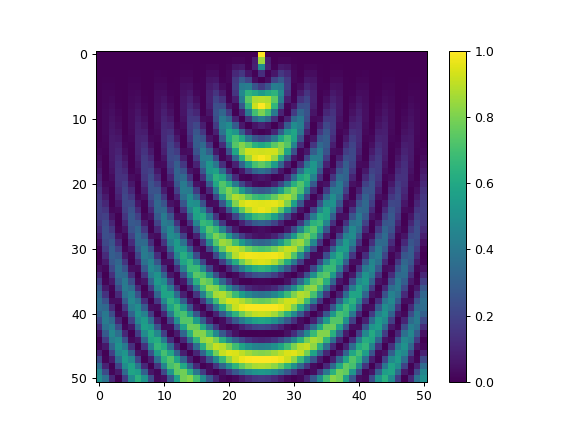

In [12]:
rabi_swp.start_amp(0)
rabi_swp.stop_amp(20)
rabi_swp.amp_points(51)
rabi_swp.start_det(-20)
rabi_swp.stop_det(20)
rabi_swp.det_points(51) 
rabi_swp.setup()

det.set_sweeper(rabi_swp)
det.time_points(11)
det.setup()

data = det.data()
print(data.shape, det.sweep_shape, det.sweep_dims, det.sweep_units)

fig, ax = plt.subplots(1,1)
im = ax.imshow(data.reshape(det.sweep_shape)[..., 0])
fig.colorbar(im)

## Together with dataset

In [ ]:
exp = d2.select_experiment('sweep test', 'None')
ds = make_dataset('hard rabi sweep', exp.exp_id, hard_sweep_detector=det)

data = det.data().reshape(-1)
ds.add_result(dict(det.get_sweep_coords_for_ds() + [(str(det.data), data)]))
ds.mark_complete()

In [ ]:
ds2 = qc.load_by_id(ds.run_id)
data = np.array(ds2.get_values('td_detector_data')).reshape(-1)

fig, ax = plt.subplots(1,1)
im = ax.imshow(data.reshape(det.sweep_shape)[..., 0])
fig.colorbar(im)

## Together with measurement object

In [38]:
exp = d2.select_experiment('sweep test', 'None')
m = MeasurementExt(station, exp, hard_sweep_detector=det)

with m.run() as datasaver:
    result = m.get_result()
    datasaver.add_result(*result)

Starting experimental run with id: 8


<IPython.core.display.Javascript object>


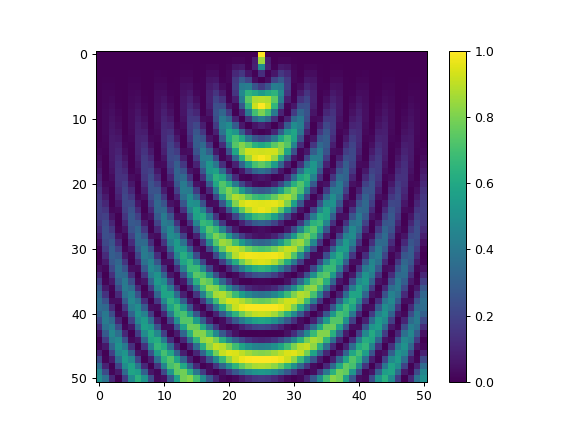

In [39]:
ds2 = qc.load_by_id(datasaver.dataset.run_id)
data = np.array(ds2.get_values('td_detector_data')).reshape(-1)

fig, ax = plt.subplots(1,1)
im = ax.imshow(data.reshape(det.sweep_shape)[..., 0])
fig.colorbar(im)